# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

# Bootstrapping

Bootstrapping is a method of random sampling with replacement. We randomly shuffle the original data points and create new data samples of the same size with replacement. As a result, we have an original sample, and new samples called the bootstrap samples. Bootstrap samples are the alternative realities of the original sample.

In this notebook, we will analyse the performance of the benchmark strategy (index reversal) using a bootstrapping methodology. The notebook is divided into the following parts:

1. [Read the Data](#read)
2. [Calculate Drawdown](#drawdown)
3. [Bootstrap Simulations](#bootstrap)
4. [Bootstrap Drawdown Distribution](#distribution)

    
## Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Statistical analysis
import scipy.stats as sc

# Import matplotlib and set the style
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

<a id='read'></a>
## Read the Data

The SPY ETF price is read from `SPY_data_15_59.csv`, and the index reversal strategy's trading signal and the cumulative returns are read from a file named `strategy_data.csv`. We will calculate the percentage returns of SPY which will be used to create bootstrap samples.

In [2]:
# Read the price data of one minute before the market close
spy_price = pd.read_csv(
    '../data_modules/SPY_data_15_59.csv', index_col=0, parse_dates=True)

# Set the date as the index for the price data
spy_price.index = pd.to_datetime(spy_price.index.date)


# Read the signal and cumulative returns of the index reversal strategy
strategy = pd.read_csv('../data_modules/strategy_data.csv',
                       index_col=0, parse_dates=True)

# Calculate percentage change of SPY
strategy['%change'] =  spy_price['Close'].pct_change()

# Preview the strategy data
strategy.head()

,signal,returns,cumulative_returns,%change
2005-01-03,0,-0.000000,1.000000,-0.008096
2005-01-04,1,-0.000000,1.000000,-0.010995
2005-01-05,1,-0.003537,0.996463,-0.003537
2005-01-06,0,0.003296,0.999747,0.003296
2005-01-07,0,-0.000000,0.999747,-0.001264


<a id='drawdown'></a>
# Calculate Drawdown

We define a function that will calculate the drawdown of the benchmark strategy and the bootstrap samples.

In [3]:
def drawdown(portfolio_value):
    # Calculate drawdown
    drawdown = min(
        (portfolio_value / np.maximum.accumulate(portfolio_value) - 1) * 100)
    
    return drawdown

<a id='bootstrap'></a>
## Bootstrap Simulation

The original data consists of 503 daily percentage changes. Using the orginal dataset, we will create new data samples of the same size by drawing from the original sample of data with replacement. 

In [4]:
# Keep only those % change values that has signal 1
original_dataset = strategy[strategy['signal'].shift(1) == 1]['%change']

len(original_dataset)

503

We run 500 bootstrap samples to form an opinion about a parameter (maximal drawdown) that characterizes the whole data set. We reshuffle the original sequence, but we do not change the results of individual trades. 

In [5]:
# Define initial capital
intial_capital = 10000

# Define the number of simulations. This is for the illustration purposes.
N = 500

# List to store bootstrap sample drawdowns
drawdowns = []

for i in range(N):
    # Resuffle the returns bootstrap sample
    bootstrap_samples = original_dataset.values
    np.random.shuffle(bootstrap_samples)
    bootstrap_samples = pd.Series(bootstrap_samples)

    # Calculate bootstrap samples drawdown
    bootstrap_portfolio_value = (
        bootstrap_samples + 1).cumprod() * intial_capital
    stats = drawdown(bootstrap_portfolio_value)
    drawdowns.append(stats)

# Calculate benchmark drawdown
benchmark_dd = drawdown(
    strategy['cumulative_returns'] * intial_capital)

# Calculate benchmark percentile w.r.t bootstrap samples drawdown
benchmark_percentile = sc.percentileofscore(drawdowns, benchmark_dd)

# Print the results
print(f'Benchmark DD: {np.round(benchmark_dd, 2)}\
\nBootstrap median DD:{np.round(np.median(drawdowns),2)}\
\nBenchmark percentile: {100-benchmark_percentile}')

Benchmark DD: -18.72
Bootstrap median DD:-18.8
Benchmark percentile: 49.199999999999996


The median maximal drawdown was around -18%, and the benchmark -18.72% drawdown is close to the 50th percentile of all scenarios. It means that there were 50% of scenarios when the maximal drawdown exceeded benchmark case.

<a id='distribution'></a>
# Bootstrap Drawdown Distribution

We define a range of percentile from 0 to 100 and store bootstrap samples drawdown for each percentile. Then we plot the drawdown distribution.

In [6]:
# Define steps for percentile
step = np.arange(0.0, 1.05, 0.05)

# Dataframe to store bootstrap drawdowns
bootstrap_distribution = pd.DataFrame()

# Calculate percentile
bootstrap_distribution['Percentile'] = step*100

# Calculate bootstrap drawdowns for each percentile
bootstrap_distribution['Drawdown'] = np.percentile(drawdowns, (1-step)*100)

bootstrap_distribution

,Percentile,Drawdown
0,0.0,-10.249655
1,5.0,-13.492807
2,10.0,-14.316355
3,15.0,-14.930173
4,20.0,-15.399922
5,25.0,-16.091575
6,30.0,-16.757244
7,35.0,-17.294391
8,40.0,-17.811469
9,45.0,-18.290476


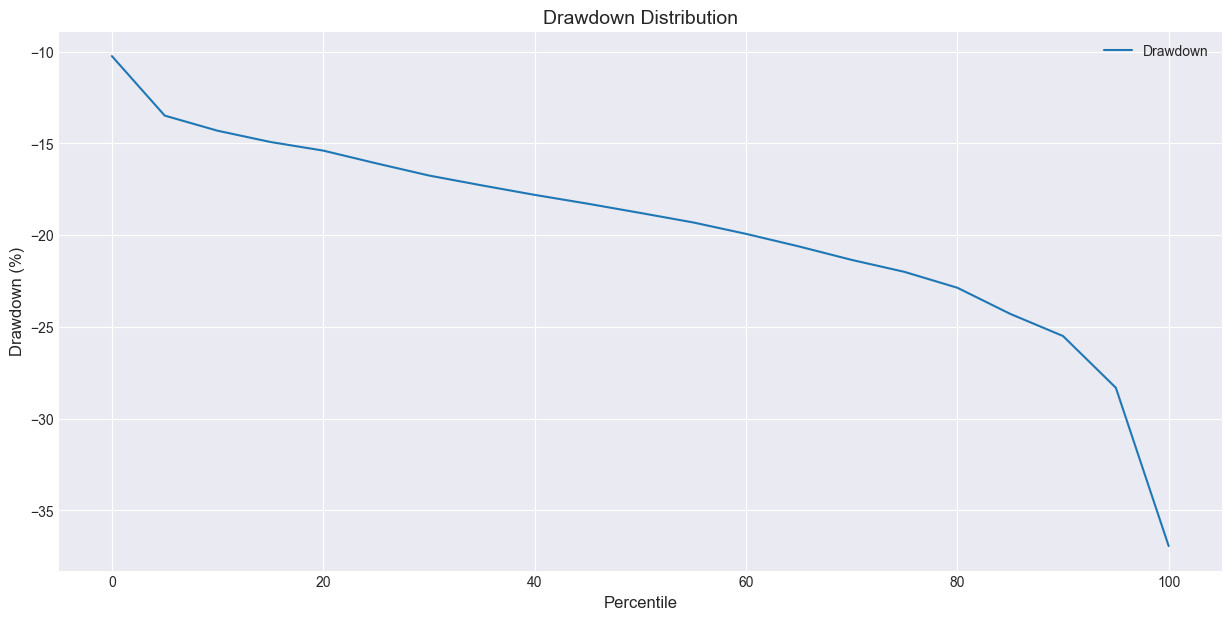

In [7]:
# Plot bootstrap drawdowns 
bootstrap_distribution.plot(x='Percentile', y='Drawdown', figsize=(15, 7))

# Set the title and axes lables
plt.title('Drawdown Distribution', fontsize=14)
plt.ylabel('Drawdown (%)', fontsize=12)
plt.xlabel('Percentile', fontsize=12)
plt.show()

In the above graph, you can see that the median drawdown was around -18%. Thus the benchmark -18.7% maximal drawdown is close to the 50th percentile of all scenarios.<br><br>